# Soil Heat Flux Methods – Example Notebook
*Generated automatically on 2025-06-13 02:19 UTC*

This notebook demonstrates example usage of the five soil‑heat‑flux Python modules included with this project:

1. **`soil_ground_heat_flux.py`** – Wang & Bou‑Zeid (2012)
2. **`liebethal_and_folken.py`** – Liebethal & Foken (2006)
3. **`wang_and_yang.py`** – Yang & Wang (2008)
4. **`gao_et_al.py`** – Gao et al. (2017)
5. **`soil_heat.py`** – Utility collection (conduction, calorimetry, diagnostics)

Each section below contains a short, self‑contained demonstration using *synthetic* data so that the examples run anywhere without external inputs.

## 1  Wang & Bou‑Zeid (2012) Green‑Function Utilities  
_`soil_ground_heat_flux.py`_

We create a synthetic 48‑point, half‑hourly surface heat‑flux series (`G0`) following a perfect daily sine wave. Using the analytical solution `soil_heat_flux_from_G0` we propagate that signal to a flux plate at 8 cm depth (`Gz`). Finally, we invert the plate series with `estimate_G0_from_Gz` and compare it against the known truth.

RMSE between true and estimated G0: 782.55 W m⁻²


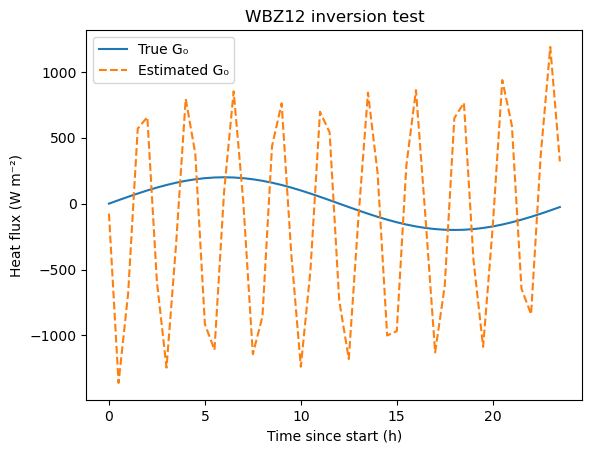

In [ ]:
import os
import sys
sys.path.insert(0, os.path.abspath("../../src"))  # adjust path as needed

import numpy as np
import matplotlib.pyplot as plt
import soil_heat 

# --- synthetic surface flux (24 h sine wave) ---------------------------
dt = 1800                      # 30‑minute steps (s)
t = np.arange(48) * dt         # 24 h series (s)
A = 200.0                      # amplitude (W m⁻²)
G0_true = A * np.sin(2 * np.pi * t / 86_400)

# --- propagate to 8 cm depth ------------------------------------------
kappa = 0.7e-6                 # thermal diffusivity (m² s⁻¹)
z_r = 0.08                     # plate depth (m)
Gz = soil_heat.soil_heat_flux_from_G0(z_r, t, G0_true, kappa)

# --- invert plate readings back to surface ----------------------------
G0_est = soil_heat.estimate_G0_from_Gz(Gz, z_r=z_r, kappa=kappa, dt=dt)
rmse = np.sqrt(np.mean((G0_true - G0_est)**2))
print(f'RMSE between true and estimated G0: {rmse:.2f} W m⁻²')

plt.figure()
plt.plot(t/3600, G0_true, label='True G₀')
plt.plot(t/3600, G0_est, '--', label='Estimated G₀')
plt.xlabel('Time since start (h)')
plt.ylabel('Heat flux (W m⁻²)')
plt.title('WBZ12 inversion test')
plt.legend(); plt.show()

## 2  Liebethal & Foken (2006) Reference Method  
_`liebethal_and_folken.py`_

The reference formulation combines a surface‑layer temperature gradient with subsurface heat storage. Here we generate a damped daily sinusoid at five depths (0.04–0.20 m) and compute the resulting surface flux using `reference_ground_heat_flux`.

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import soil_heat 

# --- synthetic temperature profile ------------------------------------
depths = np.linspace(0.04, 0.20, 5)              # 4–20 cm, exclude surface
times = np.arange(24) * 3600                     # hourly for one day (s)
T0 = 293.15                                      # base temperature (K)
amp_sfc = 8.0                                    # surface amplitude (K)
damping_depth = 0.10                             # e‑folding depth (m)
T = T0 + np.exp(-depths[:, None] / damping_depth) * amp_sfc * np.sin(2*np.pi*times/86_400)

# --- reference G₀ calculation -----------------------------------------
cv = 2.5e6                                       # J m⁻³ K⁻¹
lambda_s = 1.0                                   # W m⁻¹ K⁻¹
G0_LF = soil_heat.reference_ground_heat_flux(T, depths, times, cv, lambda_s)
plt.figure(); plt.plot(times/3600, G0_LF)
plt.xlabel('Hour of day'); plt.ylabel('G₀ (W m⁻²)')
plt.title('Liebethal & Foken Reference G₀'); plt.show()

ValueError: y and x must have identical shape

## 3  Yang & Wang (2008) Fourier‑Law Helper  
_`wang_and_yang.py`_

The **`soil_heat_flux`** function is a convenience wrapper around Fourier’s law that returns heat fluxes at layer interfaces from temperature measurements at the layer centres. We demonstrate it for a three‑layer profile with uniform spacing.

In [6]:
import numpy as np
import soil_heat 

Tz = np.array([293.15, 291.15, 289.15])   # layer‑centre temps (K)
dz = np.full(3, 0.05)                     # 5 cm layers
lambda_s = 1.2                            # W m⁻¹ K⁻¹ (constant)
G_interfaces = soil_heat.soil_heat_flux(Tz, dz, lambda_s)
print('Interface heat fluxes (W m⁻²):', G_interfaces)

TypeError: 'float' object is not subscriptable

## 4  Gao et al. (2017) Moisture‑Dependent Properties  
_`gao_et_al.py`_

Gao et al. provide empirical relationships linking volumetric water content to thermal conductivity (`λₛ`) and thermal diffusivity (`kₛ`). The cell below evaluates both curves for a range of soil moistures.

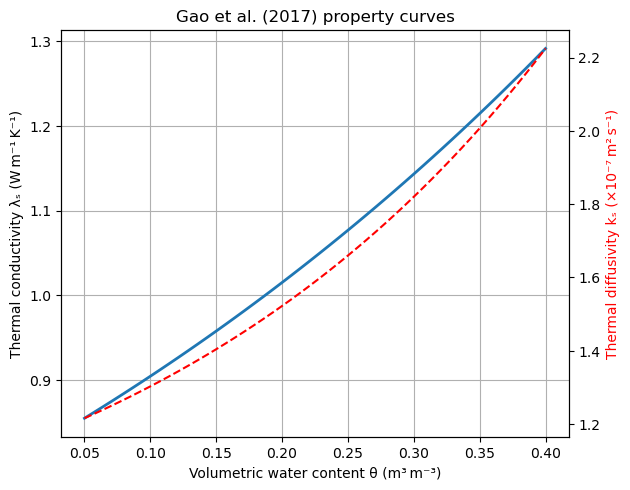

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import soil_heat 

theta = np.linspace(0.05, 0.40, 50)
lambda_s = soil_heat.lambda_s(theta)
kappa_s = soil_heat.k_s(theta)
fig, ax1 = plt.subplots()
ax1.plot(theta, lambda_s, label='λₛ', lw=2)
ax1.set_xlabel('Volumetric water content θ (m³ m⁻³)')
ax1.set_ylabel('Thermal conductivity λₛ (W m⁻¹ K⁻¹)')
ax2 = ax1.twinx()
ax2.plot(theta, kappa_s*1e7, 'r--', label='kₛ ×1e7')
ax2.set_ylabel('Thermal diffusivity kₛ (×10⁻⁷ m² s⁻¹)', color='r')
ax1.grid(True); fig.tight_layout(); plt.title('Gao et al. (2017) property curves'); plt.show()

## 5  Utility Gradient Method  
_`soil_heat.py`_

Finally, we illustrate the high‑level `compute_heat_flux_conduction` helper that takes a **pandas** `DataFrame` with temperature and soil‑moisture columns and returns a ground‑heat‑flux time series using a simple moisture‑adjusted conductivity model.

In [8]:
import pandas as pd
import numpy as np
import soil_heat as sh

# --- fabricate 48 half‑hourly samples ----------------------------------
rng = pd.date_range('2025-06-12', periods=48, freq='30min')
df = pd.DataFrame(index=rng)
np.random.seed(0)
df['T5cm'] = 15 + 5*np.sin(2*np.pi*np.arange(48)/48) + np.random.normal(0, 0.2, 48)
df['T10cm'] = 14 + 3*np.sin(2*np.pi*np.arange(48)/48 + 0.6) + np.random.normal(0, 0.2, 48)
df['VWC5cm'] = 0.25 + 0.02*np.random.randn(48)
df['VWC10cm'] = 0.26 + 0.02*np.random.randn(48)

G = sh.compute_heat_flux_conduction(df)
G.head()

2025-06-12 00:00:00    -0.411372
2025-06-12 00:30:00    -5.149441
2025-06-12 01:00:00     8.012706
2025-06-12 01:30:00    16.890184
2025-06-12 02:00:00    27.055460
Freq: 30min, Name: G_conduction, dtype: float64